# Выводы в конце ноутбука: Будем переводить с **английский** на **испанский**!

In [ ]:
! nvidia-smi

Mon Feb  7 10:40:46 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   31C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = "1"

# Seq2seq

In [ ]:
%matplotlib inline

In [ ]:
# осторожно: тетрадка старая

from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import string
import re
import random

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Данные

In [ ]:
#!wget https://download.pytorch.org/tutorial/data.zip

In [ ]:
#!unzip data.zip

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!cp "/content/drive/MyDrive/Colab Notebooks/3-Tinkoff/1-DL course/eng-spa.txt" "data/eng-spa.txt"

In [ ]:
!wc -l data/eng-spa.txt

115245 data/eng-spa.txt


In [ ]:
! head data/eng-spa.txt

Go.	Ve.
Go.	Vete.
Go.	Vaya.
Hi.	Hola.
Run!	¡Corre!
Who?	¿Quién?
Wow!	¡Órale!
Fire!	¡Fuego!
Fire!	¡Incendio!
Fire!	¡Disparad!


Делать предобработку будем по аналогии с char-level RNN-ками из предыдущих туториалов, только на этот раз нам важно отдельно запариться с EOS (end-of-sequence) — специальным токеном, который сеть будет генерировать при окончании генерации предложения.

In [ ]:
SOS_token = 0
EOS_token = 1


class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2  # Count SOS and EOS

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1
            
    def __repr__(self):
        most_popular_words = sorted(
            self.word2count.keys(), key=lambda word: self.word2count[word], reverse=True
        )[:10]
        most_popular_words = ", ".join(most_popular_words)
        return f"Language: {self.name} | Num words: {self.n_words} | Most popular: {most_popular_words}"

Все файлы в юникоде. Чтобы  облегчить нам работу, мы переведем все в ASCII, сделаем lowercase и выкинем большинство пунктуации.

In [ ]:
# "hello!" -> hello, ! 

def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    return s

При чтении данных разделим файл на строки, а строки на пары.




In [ ]:
def readLangs(lang1, lang2, reverse=False):
    print("Reading lines...")

    # Read the file and split into lines
    lines = open('data/%s-%s.txt' % (lang1, lang2), encoding='utf-8').\
        read().strip().split('\n')

    # Split every line into pairs and normalize
    pairs = [[normalizeString(s) for s in l.split('\t')] for l in lines]

    # Reverse pairs, make Lang instances
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input_lang = Lang(lang2)
        output_lang = Lang(lang1)
    else:
        input_lang = Lang(lang1)
        output_lang = Lang(lang2)

    return input_lang, output_lang, pairs

Данных у нас **много**, но мы сейчас хотим обучить что-нибудь по-быстрому, поэтому оставим оттуда только короткие и простые предложения — с длиной до 10 слов (включая пунктуацию).

In [ ]:
MAX_LENGTH = 10

eng_prefixes = (
    "i am ", "i m ",
    "he is", "he s ",
    "she is", "she s ",
    "you are", "you re ",
    "we are", "we re ",
    "they are", "they re "
)


def filterPair(p):
    return len(p[0].split(' ')) < MAX_LENGTH and \
        len(p[1].split(' ')) < MAX_LENGTH and \
        p[1].startswith(eng_prefixes)


def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]

Полный процесс такой:

- Считать текстовый файл, просплитить по линиям, а затем по парам.
- Нормализовать текст, профильтровать по длине.
- Сделать готовые списки слов из сырых предложений в каждом языке.

In [ ]:
def prepareData(lang1, lang2, reverse=False):
    input_lang, output_lang, pairs = readLangs(lang1, lang2, reverse)
    print("Read %s sentence pairs" % len(pairs))
    pairs = filterPairs(pairs)
    print("Trimmed to %s sentence pairs" % len(pairs))
    print("Counting words...")
    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, pairs

In [ ]:
input_lang, output_lang, pairs = prepareData('eng', 'spa', True)
print(random.choice(pairs))

Reading lines...
Read 115245 sentence pairs
Trimmed to 7125 sentence pairs
Counting words...
Counted words:
spa 3717
eng 2631
['eres libre de decir lo que piensas .', 'you re free to say what you think .']


In [ ]:
input_lang

Language: spa | Num words: 3717 | Most popular: ., estoy, el, de, es, no, a, soy, esta, un

In [ ]:
output_lang

Language: eng | Num words: 2631 | Most popular: ., i, m, you, re, he, is, a, to, s

In [ ]:
len(pairs)

7125

In [ ]:
pairs[24]

['estoy lleno .', 'i m full .']

## bpe tokenizer

In [ ]:
filename = "/content/data/eng-spa.txt"
bpe_model_vocab_name = 'bpe_eng-spa'

import torchtext
torchtext.data.functional.generate_sp_model(filename, vocab_size=30000, model_type='bpe', model_prefix=bpe_model_vocab_name)

In [ ]:
from torchtext.data.functional import load_sp_model
#sp_model = load_sp_model(bpe_model_vocab_name)
sp_model = load_sp_model(open(bpe_model_vocab_name+ ".model", 'rb'))

In [ ]:
from torchtext.data.functional import sentencepiece_tokenizer
sp_tokens_generator = sentencepiece_tokenizer(sp_model)

In [ ]:
def bpe_tokenizer(sentence):
  list_a = [sentence]
  list1 = list(sp_tokens_generator(list_a))[0] # squeeze
  str2 = list(' '.join(list1))
  for i in range(len(str2)):
    if (str2[i] == '▁'):
      str2[i] = ' '

  return ''.join(str2)

# bpe_tokenizer("Gooooogli es mi amigo .")

## Encoder

In [ ]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super().__init__()
        self.hidden_size = hidden_size
        # num_embedding = vocab_size_fra
        self.embedder = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size) # dim1, dim2

    def forward(self, input, hidden):
        # (batch_size, num_words) -> (batch_size, num_words, dim_1)
        embeddings = self.embedder(input).view(1, 1, -1)
        # (batch_size, num_words, dim_2)
        output, hidden = self.gru(embeddings, hidden)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [ ]:
tokens = torch.randint(0, 1000, size=(128, 40)) # слова кодируются в индексы, представим 1000 уникальных слов
print(tokens[0]) # закодированные слова
embedder = nn.Embedding(1000, 128)  # здесь лежит матрица Embedding'a 1000 на 128
embedder(tokens) # без ohe

tensor([151, 183, 274, 789,   5, 668, 813,  18, 497, 815,  84, 199, 270, 908,
        197, 802, 360, 668, 527, 246, 709, 866, 671,  94, 570, 600, 639, 293,
        397, 639, 527, 794, 503, 980,  24, 329, 566, 693, 190, 541])


tensor([[[-9.7078e-01, -6.8365e-01,  9.4388e-01,  ..., -1.0403e+00,
          -2.9556e-01, -9.7862e-02],
         [-1.8089e-01,  1.1854e+00,  8.3449e-01,  ...,  1.8250e-01,
           1.7446e-01, -3.0774e-01],
         [-3.0749e-01, -8.9212e-01, -1.1324e-01,  ..., -1.1188e+00,
           9.8434e-01, -1.4364e+00],
         ...,
         [ 5.1877e-01,  6.1175e-01, -8.4539e-02,  ..., -1.4666e+00,
           7.5529e-01,  6.6165e-01],
         [ 1.1067e+00,  5.5606e-01,  4.0233e-01,  ..., -8.4754e-01,
           5.4402e-01,  2.2547e+00],
         [-2.3076e+00, -7.9257e-01, -8.5680e-01,  ..., -7.0868e-02,
           1.3684e+00, -1.9284e-01]],

        [[ 8.8548e-02,  9.3146e-01,  9.0658e-02,  ...,  3.0520e-01,
          -2.1622e+00,  5.5578e-01],
         [-1.9889e-01, -1.6959e+00,  1.4612e+00,  ..., -1.1660e+00,
          -1.3745e+00,  1.0347e+00],
         [-8.9075e-01,  4.6991e-01, -7.1860e-01,  ...,  8.9330e-02,
           1.2588e+00,  1.4499e+00],
         ...,
         [-9.6641e-01,  4

In [ ]:
onehot = torch.nn.functional.one_hot(tokens, num_classes=1000) 
print(onehot.shape) # но нам не нужен ohe

torch.Size([128, 40, 1000])


In [ ]:
embeddingds_first_way = embedder(tokens)

In [ ]:
# another
embedding = torch.rand(32, 40, 128)
gru = torch.nn.GRU(128, 256, batch_first=True)
x, y = gru(embedding)
print(x.shape) # контекст вектор
print(y.shape) # скрытое представление

torch.Size([32, 40, 256])
torch.Size([1, 32, 256])


The Decoder
-----------

The decoder is another RNN that takes the encoder output vector(s) and
outputs a sequence of words to create the translation.




In [ ]:
class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size):
        super().__init__()
        self.hidden_size = hidden_size

        self.embedder = nn.Embedding(output_size, hidden_size) # output_size - количество слов в словаре2 (eng)
        self.gru = nn.GRU(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden, attention_false): # чтобы не переписывать train функцию attention_false
        # GRU возвращает (batch_size, seq, feature) при batch_first = True, в противном случае мы бы получили
        # (batch_size, num_words, dim)

        # (1, 1, batch_size * num_words * dim)
        output = self.embedder(input).view(1, 1, -1) # .view(words, 1, -1), words = 1, здесь реализация word2word !!
        output = F.relu(output)
        output, hidden = self.gru(output, hidden)
        # (batch_size, num_words, dim) -> (batch_size, num_words, num_classes), num_classes = valcab_size_eng
        # (batch_size, num_words, vocab_size_eng)

        # это выход из последней GRU ячейки
        output = self.out(output[0]) # self.out(np.squeeze(output, axis=0)) # так более читаемо
        output = self.softmax(output)
        return output, hidden, attention_false # чтобы не переписывать train функцию attention_false

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [ ]:
class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1, max_length=MAX_LENGTH):
        super().__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.attn = nn.Linear(self.hidden_size * 2, self.max_length)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input, hidden, encoder_outputs):
        embedded = self.embedding(input).view(1, 1, -1)
        embedded = self.dropout(embedded)

        attn_weights = F.softmax(
            self.attn(
                torch.cat((embedded[0], hidden[0]), 1)
            ), 
            dim=1
        )
        attn_applied = torch.bmm(
            attn_weights.unsqueeze(0),
            encoder_outputs.unsqueeze(0)
        )

        output = torch.cat((embedded[0], attn_applied[0]), 1)
        output = self.attn_combine(output).unsqueeze(0)

        output = F.relu(output)
        output, hidden = self.gru(output, hidden)

        output = F.log_softmax(self.out(output[0]), dim=1)
        return output, hidden, attn_weights

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

<div class="alert alert-info"><h4>Note</h4><p>There are other forms of attention that work around the length
  limitation by using a relative position approach. Read about "local
  attention" in `Effective Approaches to Attention-based Neural Machine
  Translation <https://arxiv.org/abs/1508.04025>`__.</p></div>

Training
========

Preparing Training Data
-----------------------

To train, for each pair we will need an input tensor (indexes of the
words in the input sentence) and target tensor (indexes of the words in
the target sentence). While creating these vectors we will append the
EOS token to both sequences.




In [ ]:
def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')]


def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)


def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(input_lang, pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])
    return (input_tensor, target_tensor)

This is a helper function to print time elapsed and estimated time
remaining given the current time and progress %.




In [ ]:
import time
import math


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

## Train model

In [ ]:
def train(
    input_tensor, 
    target_tensor,
    encoder, 
    decoder, 
    encoder_optimizer,
    decoder_optimizer, 
    criterion,
    max_length=MAX_LENGTH,
    teacher_forcing_ratio=0.5
):
    encoder_hidden = encoder.initHidden()

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

    loss = 0

    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(
            input_tensor[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0, 0]

    decoder_input = torch.tensor([[SOS_token]], device=device)
    decoder_hidden = encoder_hidden

    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        # y_true: [sos, i, love, pizza, eos]
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            # [0.9, 0.1, 0.0] # Without teacher forcing: use its own predictions as the next input
            # [1, 0, 0], мы как бы подсказываем ответ, а так мы можем ошибиться и получить [0, 1, 0]
            loss += criterion(decoder_output, target_tensor[di])
            decoder_input = target_tensor[di]  # Teacher forcing
            # Знаем на каком месте будет EOS_token

    else:
        # Without teacher forcing: use its own predictions as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            # beam_search is betters for decoding
            topv, topi = decoder_output.topk(1) # жадно выбираем предсказания, самый лучший берем, а могли бы равновероятно выбирать из top-k
            decoder_input = topi.squeeze().detach()  # detach from history as input
            loss += criterion(decoder_output, target_tensor[di])
            if decoder_input.item() == EOS_token: # Не знаем на каком месте будет EOS_token, если плохо обучились, то EOS токена может не быть, поэтому подаем искусственно
                # y_true: [sos, i, eos]
                # [sos, i, eos, love] # если у нас после EOS_token будет что-то идти это плохо, поэтому мы не даем ему искусственно обучаться после EOS_token, просто break 
                break

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length

In [ ]:
def trainIters(encoder, decoder, n_iters, print_every=1000, plot_every=100, learning_rate=0.01, teacher_forcing_ratio = 0.5):
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
    training_pairs = [tensorsFromPair(random.choice(pairs))
                      for i in range(n_iters)]
    criterion = nn.NLLLoss()

    for iter in range(1, n_iters + 1):
        training_pair = training_pairs[iter - 1]
        input_tensor = training_pair[0]
        target_tensor = training_pair[1]

        loss = train(input_tensor, target_tensor, encoder,
                     decoder, encoder_optimizer, decoder_optimizer, criterion, teacher_forcing_ratio=teacher_forcing_ratio)
        print_loss_total += loss
        plot_loss_total += loss

        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, iter / n_iters),
                                         iter, iter / n_iters * 100, print_loss_avg))

        if iter % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

    showPlot(plot_losses)

Plotting results
----------------

Plotting is done with matplotlib, using the array of loss values
``plot_losses`` saved while training.




In [ ]:
import matplotlib.pyplot as plt
plt.switch_backend('agg')
import matplotlib.ticker as ticker
import numpy as np


def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

Evaluation
==========

Evaluation is mostly the same as training, but there are no targets so
we simply feed the decoder's predictions back to itself for each step.
Every time it predicts a word we add it to the output string, and if it
predicts the EOS token we stop there. We also store the decoder's
attention outputs for display later.




In [ ]:
def evaluate(encoder, decoder, sentence, max_length=MAX_LENGTH):
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)
        input_length = input_tensor.size()[0]
        encoder_hidden = encoder.initHidden()

        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei],
                                                     encoder_hidden)
            encoder_outputs[ei] += encoder_output[0, 0]

        decoder_input = torch.tensor([[SOS_token]], device=device)  # SOS

        decoder_hidden = encoder_hidden

        decoded_words = []
        decoder_attentions = torch.zeros(max_length, max_length)

        for di in range(max_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            decoder_attentions[di] = decoder_attention.data
            topv, topi = decoder_output.data.topk(1)
            if topi.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(output_lang.index2word[topi.item()])

            decoder_input = topi.squeeze().detach()

        return decoded_words, decoder_attentions[:di + 1]

In [ ]:
def evaluateRandomly(encoder, decoder, n=10):
    for i in range(n):
        pair = random.choice(pairs)
        print('>', pair[0])
        print('=', pair[1])
        output_words, attentions = evaluate(encoder, decoder, pair[0])
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')

## Visualizing Attention




In [ ]:
%matplotlib inline

For a better viewing experience we will do the extra work of adding axes
and labels:




In [ ]:
def showAttention(input_sentence, output_words, attentions):
    # Set up figure with colorbar
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions.numpy(), cmap='bone')
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticklabels([''] + input_sentence.split(' ') +
                       ['<EOS>'], rotation=90)
    ax.set_yticklabels([''] + output_words)

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()


def evaluateAndShowAttention(encoder, decoder, input_sentence):
    # input_sentence = bpe_tokenizer(input_sentence)
    output_words, attentions = evaluate(
        encoder, decoder, input_sentence)
    print('input =', input_sentence)
    print('output =', ' '.join(output_words))
    showAttention(input_sentence, output_words, attentions)

The whole training process looks like this:

-  Start a timer
-  Initialize optimizers and criterion
-  Create set of training pairs
-  Start empty losses array for plotting

Then we call ``train`` many times and occasionally print the progress (%
of examples, time so far, estimated time) and average loss.




In [ ]:
sentences0 = ["a de que .",
              " mi amigo ."]

# Эксперимент 1: **TeacherForcing=1.0** & **Decoder_with_Attention=True**

0m 10s (- 33m 32s) (200 0%) 4.5253
0m 19s (- 31m 25s) (400 1%) 3.4132
0m 28s (- 30m 48s) (600 1%) 3.3073
0m 37s (- 30m 18s) (800 2%) 3.1929
0m 46s (- 30m 5s) (1000 2%) 3.1302
0m 55s (- 29m 44s) (1200 3%) 3.0644
1m 4s (- 29m 29s) (1400 3%) 3.0453
1m 13s (- 29m 22s) (1600 4%) 2.9230
1m 22s (- 29m 9s) (1800 4%) 2.8952
1m 31s (- 28m 54s) (2000 5%) 2.8168
1m 40s (- 28m 42s) (2200 5%) 2.8476
1m 49s (- 28m 36s) (2400 6%) 2.7654
1m 58s (- 28m 27s) (2600 6%) 2.6952
2m 8s (- 28m 23s) (2800 7%) 2.7431
2m 17s (- 28m 16s) (3000 7%) 2.6340
2m 26s (- 28m 8s) (3200 8%) 2.5804
2m 35s (- 27m 56s) (3400 8%) 2.4616
2m 45s (- 27m 48s) (3600 9%) 2.4513
2m 54s (- 27m 42s) (3800 9%) 2.4282
3m 4s (- 27m 37s) (4000 10%) 2.4390
3m 13s (- 27m 30s) (4200 10%) 2.3969
3m 22s (- 27m 20s) (4400 11%) 2.3223
3m 31s (- 27m 10s) (4600 11%) 2.3201
3m 40s (- 27m 0s) (4800 12%) 2.2714
3m 50s (- 26m 50s) (5000 12%) 2.3250
3m 59s (- 26m 43s) (5200 13%) 2.2247
4m 8s (- 26m 33s) (5400 13%) 2.2341
4m 17s (- 26m 24s) (5600 14%) 2.

<Figure size 432x288 with 0 Axes>

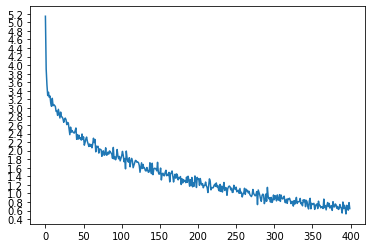

In [ ]:
teacher_forcing_ratio = 1.0

hidden_size = 256

encoder1 = EncoderRNN(input_lang.n_words, hidden_size).to(device)
attn_decoder1 = AttnDecoderRNN(hidden_size, output_lang.n_words, dropout_p=0.1).to(device)

trainIters(encoder1, attn_decoder1, 40000, print_every=200, teacher_forcing_ratio=teacher_forcing_ratio) # 40000

In [ ]:
evaluateRandomly(encoder1, attn_decoder1)

> ella es agresiva .
= she is aggressive .
< i m m . <EOS>

> voy a una reunion .
= i m going to a meeting .
< i m m . <EOS>

> los osos me dan miedo .
= i am afraid of bears .
< i m m . <EOS>

> estoy enferma y agotada de el .
= i am sick and tired of him .
< i m m . <EOS>

> solo estoy haciendo mi trabajo .
= i m just doing my job .
< i m m . <EOS>

> estamos cuidando una casa .
= we re housesitting .
< i m m . <EOS>

> el es muy famoso en japon tambien .
= he is also very famous in japan .
< i m m . <EOS>

> esta de buen humor .
= she is in a very good mood .
< i m m . <EOS>

> siempre estoy listo para ayudarte .
= i am always ready to help you .
< i m m . <EOS>

> ni siquiera estas sudando .
= you re not even sweating .
< i m m . <EOS>



input = a de que .
output = i m afraid you re fine . <EOS>


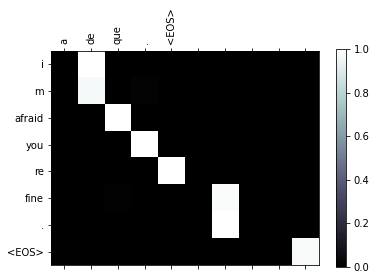

In [ ]:
evaluateAndShowAttention(encoder1, attn_decoder1, sentences0[0])

## Решение проблемы неизвестных слов с помощью bpe токенайзера (byte-pair), демонстрация

input =  mi amigo .
output = you re my friend . <EOS>


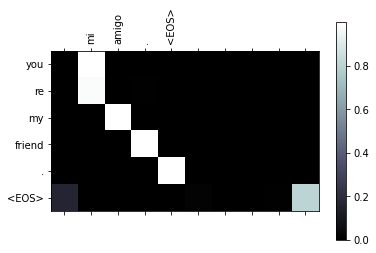

In [ ]:
# evaluateAndShowAttention(encoder1, attn_decoder1, "elle a cinq ans de moins que moi .")
# evaluateAndShowAttention(encoder1, attn_decoder1, "elle est trop petit .")

# работа bpe с неизвестными словами
evaluateAndShowAttention(encoder1, attn_decoder1, sentences0[1]) # неправильная фраза на испанском

# на вход язык перевода подан)
# evaluateAndShowAttention(encoder1, attn_decoder1, "Googlee iti my frieend !") # фраза на английском с ошибками

# Эксперимент 2: **TeacherForcing=0.5** & **Decoder_with_Attention=True**

0m 8s (- 29m 14s) (200 0%) 4.0055
0m 17s (- 28m 51s) (400 1%) 3.5342
0m 26s (- 28m 30s) (600 1%) 3.5349
0m 34s (- 28m 20s) (800 2%) 3.5270
0m 43s (- 28m 8s) (1000 2%) 3.3379
0m 52s (- 28m 5s) (1200 3%) 3.4121
1m 0s (- 28m 1s) (1400 3%) 3.3648
1m 10s (- 28m 9s) (1600 4%) 3.2472
1m 18s (- 27m 53s) (1800 4%) 3.1207
1m 27s (- 27m 42s) (2000 5%) 3.1259
1m 36s (- 27m 31s) (2200 5%) 2.9269
1m 44s (- 27m 22s) (2400 6%) 2.9537
1m 53s (- 27m 13s) (2600 6%) 2.9691
2m 2s (- 27m 3s) (2800 7%) 2.9757
2m 10s (- 26m 54s) (3000 7%) 2.8418
2m 19s (- 26m 45s) (3200 8%) 2.7856
2m 28s (- 26m 36s) (3400 8%) 2.8160
2m 37s (- 26m 28s) (3600 9%) 2.8845
2m 45s (- 26m 18s) (3800 9%) 2.8116
2m 54s (- 26m 9s) (4000 10%) 2.8326
3m 3s (- 26m 0s) (4200 10%) 2.7582
3m 11s (- 25m 53s) (4400 11%) 2.7214
3m 20s (- 25m 45s) (4600 11%) 2.6685
3m 29s (- 25m 38s) (4800 12%) 2.8323
3m 38s (- 25m 28s) (5000 12%) 2.6338
3m 47s (- 25m 19s) (5200 13%) 2.6014
3m 55s (- 25m 10s) (5400 13%) 2.6367
4m 4s (- 25m 2s) (5600 14%) 2.5837


<Figure size 432x288 with 0 Axes>

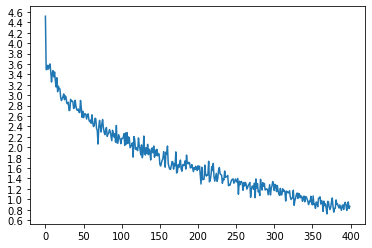

In [ ]:
teacher_forcing_ratio = 0.5

hidden_size = 256

encoder2 = EncoderRNN(input_lang.n_words, hidden_size).to(device)
attn_decoder2 = AttnDecoderRNN(hidden_size, output_lang.n_words, dropout_p=0.1).to(device)

trainIters(encoder2, attn_decoder2, 40000, print_every=200, teacher_forcing_ratio=teacher_forcing_ratio)

In [ ]:
evaluateRandomly(encoder2, attn_decoder2)

> yo no me quejo .
= i m not complaining .
< i m not done . <EOS>

> no soy tan rico como tom .
= i m not as rich as tom .
< i m not rich enough as tom . <EOS>

> ella es increiblemente ingenua .
= she s unbelievably naive .
< she s re up . <EOS>

> estoy muy cansado .
= i m so tired .
< i m very tired . <EOS>

> el es un jugador de beisbol famoso .
= he is a famous baseball player .
< he is a baseball baseball player . <EOS>

> soy un paciente con cancer .
= i m a cancer patient .
< i m a patient patient man . <EOS>

> estoy jugando con mis amigos .
= i m playing with my friends .
< i m playing with my friends . <EOS>

> el esta demente .
= he s demented .
< he s demented . <EOS>

> vamos camino a casa .
= we re on our way home .
< we re going home . <EOS>

> esta tratando de perder peso .
= she is trying to lose weight .
< he is trying to lose weight . <EOS>



input = a de que .
output = he is coming to succeed . <EOS>


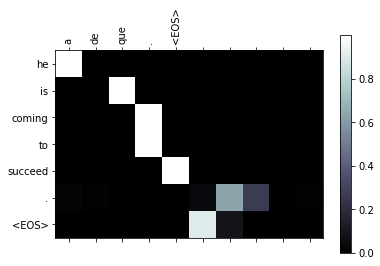

input =  mi amigo .
output = you re my friend friend . <EOS>


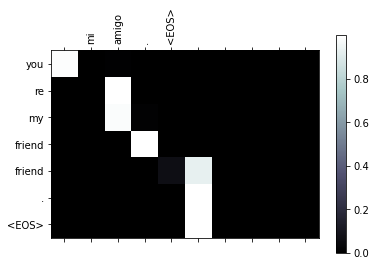

In [ ]:
evaluateAndShowAttention(encoder2, attn_decoder2, sentences0[0])

evaluateAndShowAttention(encoder2, attn_decoder2, sentences0[1])

# Эксперимент 3: **TeacherForcing=0.0** & **Decoder_with_Attention=True**

0m 8s (- 29m 5s) (200 0%) 3.9025
0m 17s (- 28m 23s) (400 1%) 3.5833
0m 25s (- 28m 10s) (600 1%) 3.6335
0m 34s (- 28m 9s) (800 2%) 3.6230
0m 43s (- 28m 6s) (1000 2%) 3.5762
0m 51s (- 27m 49s) (1200 3%) 3.4643
1m 0s (- 27m 41s) (1400 3%) 3.4503
1m 9s (- 27m 39s) (1600 4%) 3.3995
1m 17s (- 27m 34s) (1800 4%) 3.3541
1m 26s (- 27m 30s) (2000 5%) 3.2381
1m 35s (- 27m 24s) (2200 5%) 3.1934
1m 44s (- 27m 14s) (2400 6%) 3.1357
1m 53s (- 27m 10s) (2600 6%) 3.1505
2m 2s (- 27m 1s) (2800 7%) 3.0203
2m 11s (- 26m 56s) (3000 7%) 3.0470
2m 20s (- 26m 55s) (3200 8%) 3.1698
2m 29s (- 26m 50s) (3400 8%) 2.9802
2m 38s (- 26m 41s) (3600 9%) 2.9983
2m 47s (- 26m 32s) (3800 9%) 2.9115
2m 56s (- 26m 24s) (4000 10%) 2.7612
3m 5s (- 26m 17s) (4200 10%) 2.9871
3m 13s (- 26m 6s) (4400 11%) 2.7926
3m 22s (- 25m 59s) (4600 11%) 2.8526
3m 31s (- 25m 50s) (4800 12%) 2.8430
3m 40s (- 25m 40s) (5000 12%) 2.7589
3m 48s (- 25m 31s) (5200 13%) 2.7109
3m 57s (- 25m 22s) (5400 13%) 2.7456
4m 6s (- 25m 14s) (5600 14%) 2.799

<Figure size 432x288 with 0 Axes>

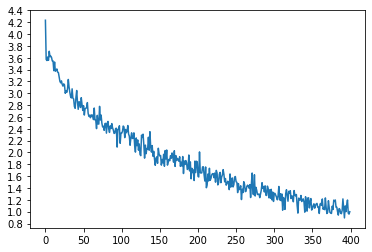

In [ ]:
teacher_forcing_ratio = 0.0

hidden_size = 256

encoder3 = EncoderRNN(input_lang.n_words, hidden_size).to(device)
attn_decoder3 = AttnDecoderRNN(hidden_size, output_lang.n_words, dropout_p=0.1).to(device)

trainIters(encoder3, attn_decoder3, 40000, print_every=200, teacher_forcing_ratio=teacher_forcing_ratio)

In [ ]:
evaluateRandomly(encoder3, attn_decoder3)

> me temo que te perderas .
= i am afraid that you will get lost .
< i m afraid you will come . . <EOS>

> eres un travieso .
= you are naughty .
< you are an . <EOS>

> yo estoy muy cansado como para seguir caminando .
= i m too tired to walk any longer .
< i am too tired to walk you walk . <EOS>

> lo estamos investigando .
= we re investigating it .
< we re investigating it . <EOS>

> no sos estupida .
= you re not stupid .
< you re not stupid . <EOS>

> no estoy muy seguro .
= i m not really sure .
< i m not sure . . <EOS>

> no voy en serio .
= i m not serious .
< i m not serious . <EOS>

> soy daltonico .
= i m color blind .
< i m a . . <EOS>

> eres como tom .
= you re like tom .
< you re like tom . <EOS>

> no te estoy culpando .
= i m not blaming you .
< i m not blaming you <EOS>



input = a de que .
output = i m afraid to will get . <EOS>


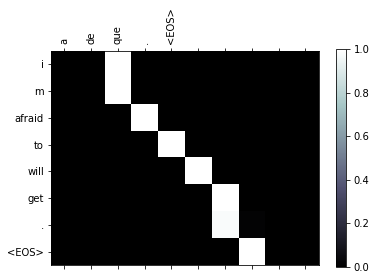

input =  mi amigo .
output = i m my friend . <EOS>


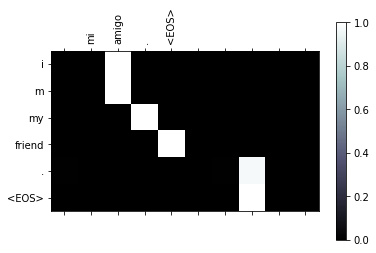

In [ ]:
evaluateAndShowAttention(encoder3, attn_decoder3, sentences0[0])

evaluateAndShowAttention(encoder3, attn_decoder3, sentences0[1])

# Эксперимент 4: **TeacherForcing=1.0** & **Decoder_with_Attention=False**

0m 9s (- 32m 39s) (200 0%) 4.3854
0m 18s (- 30m 12s) (400 1%) 3.3752
0m 26s (- 29m 25s) (600 1%) 3.4132
0m 35s (- 28m 55s) (800 2%) 3.3906
0m 43s (- 28m 35s) (1000 2%) 3.2159
0m 52s (- 28m 8s) (1200 3%) 3.0424
1m 0s (- 27m 52s) (1400 3%) 3.1307
1m 9s (- 27m 36s) (1600 4%) 3.0081
1m 17s (- 27m 15s) (1800 4%) 2.8798
1m 25s (- 26m 57s) (2000 5%) 2.7921
1m 33s (- 26m 45s) (2200 5%) 2.8213
1m 41s (- 26m 32s) (2400 6%) 2.7981
1m 49s (- 26m 18s) (2600 6%) 2.7426
1m 57s (- 26m 3s) (2800 7%) 2.6751
2m 6s (- 25m 56s) (3000 7%) 2.7031
2m 14s (- 25m 45s) (3200 8%) 2.6564
2m 22s (- 25m 34s) (3400 8%) 2.5770
2m 30s (- 25m 23s) (3600 9%) 2.5384
2m 38s (- 25m 13s) (3800 9%) 2.5767
2m 47s (- 25m 9s) (4000 10%) 2.6038
2m 55s (- 24m 59s) (4200 10%) 2.4560
3m 4s (- 24m 52s) (4400 11%) 2.4941
3m 13s (- 24m 46s) (4600 11%) 2.4830
3m 21s (- 24m 36s) (4800 12%) 2.3533
3m 29s (- 24m 28s) (5000 12%) 2.3817
3m 38s (- 24m 19s) (5200 13%) 2.3375
3m 46s (- 24m 12s) (5400 13%) 2.3424
3m 55s (- 24m 3s) (5600 14%) 2.3

<Figure size 432x288 with 0 Axes>

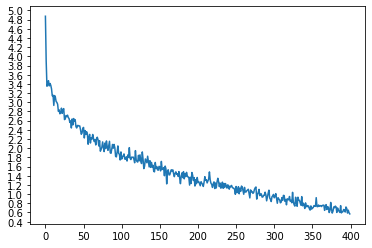

In [ ]:
teacher_forcing_ratio = 1.0

hidden_size = 256

encoder4 = EncoderRNN(input_lang.n_words, hidden_size).to(device)
attn_off_decoder4 = DecoderRNN(hidden_size, output_lang.n_words).to(device)

trainIters(encoder4, attn_off_decoder4, 40000, print_every=200, teacher_forcing_ratio=teacher_forcing_ratio)

# Будущие улучшения (не для проверки):

In [ ]:
# >>> import torch

# >>> from navec import Navec
# >>> from slovnet.model.emb import NavecEmbedding

# >>> path = 'hudlit_12B_500K_300d_100q.tar'  # 51MB
# >>> navec = Navec.load(path)  # ~1 sec, ~100MB RAM

# >>> words = ['навек', '<unk>', '<pad>']
# >>> ids = [navec.vocab[_] for _ in words]

# >>> emb = NavecEmbedding(navec)
# >>> input = torch.tensor(ids)

# >>> emb(input)  # 3 x 300
# tensor([[ 4.2000e-01,  3.6666e-01,  1.7728e-01,
#         [ 1.6954e-01, -4.6063e-01,  5.4519e-01,
#         [ 0.0000e+00,  0.0000e+00,  0.0000e+00,

In [ ]:
# Прикрутить эмбеддинги предобученные один для испанского, другой для английского, здесь для русского
# https://natasha.github.io/navec/

# **Выводы:**

1. Обучил seq2seq для перевода c **English** на **Spain**.
2. Решил проблему неизвестных слов с помощью **bpe токенайзера** (byte-pair).
3. Провел ряд экспериментов, оказалось, что с TeacherForcing (**TF**) = **1.0** loss = **0.596**, TF = **0.5** loss = **0.826**, **TF** = **0.0** loss = **0.973**.
4. Провел ряд экспериментов, оказалось, что **с Attention** и TF=1.0 loss = **0.596**, **без Attention** loss = **0.618**.

**Итог:** 
1. Teacher Forcing улучшает точность модели в разы, лучше его использовать всегда.
2. C Attention сеть работает лучше.

**Off-topic** (будущие улучшения):
1. Заменил embeddings with pre-trained word embeddings **word2vec** или GloVe.
2. улучшить распознавание неизвестных слов с помощью VAE подбирать наиболее близкое по вектору